In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia
!unzip udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.81GB/s]
Archive:  udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


#**Cargar archivos como Dataframes**

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
auxiliar_df = train_df.copy()

In [4]:
train_df.columns

Index(['ID', 'PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO',
       'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA',
       'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE',
       'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD',
       'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1',
       'F_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'INDICADOR_1', 'INDICADOR_2',
       'INDICADOR_3', 'INDICADOR_4'],
      dtype='object')

## **Funciones de Limpieza**

### **Rendimiento Global**

In [5]:
def rendimientoglobal(df):
  map_dict = {
    "alto":3,
    "medio-alto":2,
    "medio-bajo":1,
    "bajo": 0
  }
  df['RENDIMIENTO_GLOBAL'] = df['RENDIMIENTO_GLOBAL'].map(map_dict)

rendimientoglobal(auxiliar_df)

### **Rendimiento Global Reverso**

In [6]:
def rendimientoglobalreverse(df):
    df['RENDIMIENTO_GLOBAL'] = df['RENDIMIENTO_GLOBAL'].round().astype(int)
    map_dict = {
        3: "alto",
        2: "medio-alto",
        1: "medio-bajo",
        0: "bajo"
    }
    df['RENDIMIENTO_GLOBAL'] = df['RENDIMIENTO_GLOBAL'].map(map_dict)
    return df

### **Estrato**

In [7]:
def estrato(df):
    map_dict = {
        'Estrato 1': 1,
        'Estrato 2': 3,
        'Estrato 3': 4,
        'Estrato 4': 5,
        'Estrato 5': 6,
        'Estrato 6': 7,
        'Sin Estrato': 2
    }

    df['F_ESTRATOVIVIENDA'] = df['F_ESTRATOVIVIENDA'].map(map_dict)

    # Calcula la moda de manera segura
    modas = df['F_ESTRATOVIVIENDA'].mode()
    if not modas.empty:
        moda = modas.iloc[0]
    else:
        moda = 0  # valor por defecto si toda la columna es nula

    # Reemplaza valores nulos por la moda
    def generar_valores(row):
        if pd.isna(row):
            return moda
        return row

    df['F_ESTRATOVIVIENDA'] = df['F_ESTRATOVIVIENDA'].apply(generar_valores)



### **Internet**

In [8]:
#NUEVO - la probabilidad no es una constante, es el promedio de personas que dijieron que si
import random
def internet(df):
  map_dict = {
    'Si': 1,
    'No': 0,
  }
  df['F_TIENEINTERNET'] = df['F_TIENEINTERNET'].map(map_dict)
  percent=np.round(df['F_TIENEINTERNET'].mean(),4)

  def assign_value(row):
    est_value=row['F_ESTRATOVIVIENDA']
    if pd.isnull(row['F_TIENEINTERNET']):
        if est_value > 2:
            return 1
        elif np.round(random.random(),4) <= percent:
            return 1
        else:
            return 0
    else:
        return row['F_TIENEINTERNET']

  df['F_TIENEINTERNET'] = df.apply(assign_value, axis=1)

### **Matricula Propia**

In [9]:
def matriculapropia(df):

    # Agrupar por departamento y calcular la media y desviación estándar del rendimiento global
    res_mean = auxiliar_df.groupby('E_PAGOMATRICULAPROPIO')["RENDIMIENTO_GLOBAL"].mean()
    res_std = auxiliar_df.groupby('E_PAGOMATRICULAPROPIO')["RENDIMIENTO_GLOBAL"].std()

    # Mapear los resultados en el DataFrame
    df['E_PAGOMATRICULAPROPIO'] = df['E_PAGOMATRICULAPROPIO'].map(res_mean)

    # Función para generar valores aleatorios con la misma media y desviación estándar
    def generar_valores_normales(row):
        if pd.isna(row):  # Si el valor es nulo
            mean = res_mean.mean()
            std = res_std.mean()
            return np.random.normal(mean, std)
        return row

    # Aplicar la función para sustituir los valores nulos con una distribución normal equivalente
    df['E_PAGOMATRICULAPROPIO'] = df['E_PAGOMATRICULAPROPIO'].apply(generar_valores_normales)

### **Horas que Trabaja**

In [10]:
def horassemanatrabaja(df):
    map_dict = {
        '0': 5,
        'Entre 11 y 20 horas': 3,
        'Entre 21 y 30 horas': 2,
        'Menos de 10 horas': 4,
        'Más de 30 horas': 1
    }

    df['E_HORASSEMANATRABAJA'] = df['E_HORASSEMANATRABAJA'].map(map_dict)

    # calcula la moda de forma segura
    modas = df['E_HORASSEMANATRABAJA'].mode()
    if not modas.empty:
        moda = modas.iloc[0]
    else:
        moda = 0

    # rellena los valores nulos con la moda
    df['E_HORASSEMANATRABAJA'] = df['E_HORASSEMANATRABAJA'].fillna(moda)

### **Valor de la Matricula**

In [11]:
def valormatriculauniversidad(df):
    map_dict = {
        'Entre 1 millón y menos de 2.5 millones': 1,
        'Entre 2.5 millones y menos de 4 millones': 2,
        'Entre 4 millones y menos de 5.5 millones': 6,
        'Entre 5.5 millones y menos de 7 millones': 7,
        'Entre 500 mil y menos de 1 millón': 3,
        'Menos de 500 mil': 5,
        'Más de 7 millones': 8,
        'No pagó matrícula': 4
    }

    df['E_VALORMATRICULAUNIVERSIDAD'] = df['E_VALORMATRICULAUNIVERSIDAD'].map(map_dict)

    # calcula la moda de forma segura
    modas = df['E_VALORMATRICULAUNIVERSIDAD'].mode()
    if not modas.empty:
        moda = modas.iloc[0]
    else:
        moda = 0  # valor por defecto si no hay datos válidos

    # reemplaza nulos con la moda
    df['E_VALORMATRICULAUNIVERSIDAD'] = df['E_VALORMATRICULAUNIVERSIDAD'].fillna(moda)

### **Educación de Padre**

In [12]:
def educacionpadre(df):
    map_dict = {
        'Educación profesional completa': 11,
        'Educación profesional incompleta': 10,
        'Ninguno': 1,
        'No Aplica': 2,
        'No sabe': 3,
        'Postgrado': 12,
        'Primaria completa': 5,
        'Primaria incompleta': 4,
        'Secundaria (Bachillerato) completa': 8,
        'Secundaria (Bachillerato) incompleta': 6,
        'Técnica o tecnológica completa': 9,
        'Técnica o tecnológica incompleta': 7
    }

    df['F_EDUCACIONPADRE'] = df['F_EDUCACIONPADRE'].map(map_dict)

    modas = df['F_EDUCACIONPADRE'].mode()
    moda = modas.iloc[0] if not modas.empty else 0

    df['F_EDUCACIONPADRE'] = df['F_EDUCACIONPADRE'].fillna(moda)


### **Educación de Madre**

In [13]:
def educacionmadre(df):
    map_dict = {
        'Educación profesional completa': 11,
        'Educación profesional incompleta': 10,
        'Ninguno': 1,
        'No Aplica': 2,
        'No sabe': 3,
        'Postgrado': 12,
        'Primaria completa': 5,
        'Primaria incompleta': 4,
        'Secundaria (Bachillerato) completa': 7,
        'Secundaria (Bachillerato) incompleta': 6,
        'Técnica o tecnológica completa': 9,
        'Técnica o tecnológica incompleta': 8
    }

    df['F_EDUCACIONMADRE'] = df['F_EDUCACIONMADRE'].map(map_dict)

    # calcula la moda de forma segura
    modas = df['F_EDUCACIONMADRE'].mode()
    if not modas.empty:
        moda = modas.iloc[0]
    else:
        moda = 0  # o el valor que prefieras por defecto

    # rellena nulos con la moda
    df['F_EDUCACIONMADRE'] = df['F_EDUCACIONMADRE'].fillna(moda)

### **Periodo**

In [14]:
def periodo(df):
    df['PERIODO_ACADEMICO'] = df['PERIODO_ACADEMICO'].astype(str)

    map_dict = {
        "20183": 5,
        "20184": 1,
        "20194": 9,
        "20195": 3,
        "20196": 4,
        "20202": 8,
        "20203": 6,
        "20212": 2,
        "20213": 7
    }

    df['PERIODO_ACADEMICO'] = df['PERIODO_ACADEMICO'].map(map_dict)

    modas = df['PERIODO_ACADEMICO'].mode()
    if not modas.empty:
        moda = modas.iloc[0]
    else:
        moda = 0  # o el valor que prefieras como predeterminado

    df['PERIODO_ACADEMICO'] = df['PERIODO_ACADEMICO'].fillna(moda)

### **Departamento**

In [15]:
def departamento(df):

    # Agrupar por departamento y calcular la media y desviación estándar del rendimiento global
    res_mean = auxiliar_df.groupby('E_PRGM_DEPARTAMENTO')["RENDIMIENTO_GLOBAL"].mean()

    # Mapear los resultados en el DataFrame
    df['E_PRGM_DEPARTAMENTO'] = df['E_PRGM_DEPARTAMENTO'].map(res_mean)

    # Función para generar valores aleatorios con la misma media y desviación estándar
    def generar_valores_normales(row):
        if pd.isna(row):  # Si el valor es nulo
            mean = auxiliar_df['RENDIMIENTO_GLOBAL'].mean()
            return mean
        return row

    # Aplicar la función para sustituir los valores nulos con una distribución normal equivalente
    df['E_PRGM_DEPARTAMENTO'] = df['E_PRGM_DEPARTAMENTO'].apply(generar_valores_normales)


### **Programa Acádemico**

In [16]:
def programaacademico(df):

    # Agrupar por departamento y calcular la media y desviación estándar del rendimiento global
    res_mean = auxiliar_df.groupby('E_PRGM_ACADEMICO')["RENDIMIENTO_GLOBAL"].mean()

    # Mapear los resultados en el DataFrame
    df['E_PRGM_ACADEMICO'] = df['E_PRGM_ACADEMICO'].map(res_mean)

    # Función para generar valores aleatorios con la misma media y desviación estándar
    def generar_valores_normales(row):
        if pd.isna(row):  # Si el valor es nulo
            mean = auxiliar_df['RENDIMIENTO_GLOBAL'].mean()
            return mean
        return row

    # Aplicar la función para sustituir los valores nulos con una distribución normal equivalente
    df['E_PRGM_ACADEMICO'] = df['E_PRGM_ACADEMICO'].apply(generar_valores_normales)

### **Columnas binarias**

In [17]:
def columnas_binarias(df):
    """Convierte las columnas binarias 'Si'/'No' a 1/0"""
    binarias = [
        'F_TIENELAVADORA',
        'F_TIENEAUTOMOVIL',
        'E_PRIVADO_LIBERTAD',
        'F_TIENECOMPUTADOR',
        'F_TIENEINTERNET.1'
    ]
    for col in binarias:
        if col in df.columns:
            df[col] = df[col].map({'Si': 1, 'No': 0})
            df[col] = df[col].fillna(0)  # opcional: llena nulos con 0

## **Limpieza Total**

In [18]:
def limpiar_df(df, predict=False, test=False):
  global auxiliar_df

  # Ensure auxiliar_df is initialized and its 'RENDIMIENTO_GLOBAL' is numeric.
  # This makes the cleaning process robust against 'auxiliar_df' not being processed externally.
  if 'auxiliar_df' not in globals() or not (isinstance(auxiliar_df, pd.DataFrame) and pd.api.types.is_numeric_dtype(auxiliar_df.get('RENDIMIENTO_GLOBAL', pd.Series(dtype=object)))):
      if 'train_df' in globals():
          auxiliar_df = globals()['train_df'].copy()
          rendimientoglobal(auxiliar_df)
      else:
          # This indicates 'train_df' itself is not loaded. Cannot proceed with auxiliary calculations.
          raise RuntimeError("Error: 'train_df' not found globally. Cannot initialize 'auxiliar_df'.")

  if not predict:
    if not test:
      rendimientoglobal(df)
    estrato(df)
    internet(df)
    matriculapropia(df)
    valormatriculauniversidad(df)
    educacionpadre(df)
    educacionmadre(df)
    horassemanatrabaja(df)
    departamento(df)
    programaacademico(df)
    periodo(df)
    columnas_binarias(df)
    return df
  elif predict:
    rendimientoglobal(df)

In [19]:
train_df2 = limpiar_df(train_df)
test_df2 = limpiar_df(test_df, test=True)

# **XGBoost Classifier**

In [20]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df = train_df2.copy()

# Separar características (X) y la variable objetivo (y)
X = df.drop(columns=["RENDIMIENTO_GLOBAL","ID"], axis=1)
y = df["RENDIMIENTO_GLOBAL"]

# Dividir el conjunto de datos en entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Inicializar el modelo de XGBoost para clasificación
xgb_classifier = xgb.XGBClassifier(n_estimators=100,
                                   learning_rate=0.4,
                                   max_depth=5,
                                   random_state=42)

# Entrenar el modelo
xgb_classifier.fit(X_train, y_train)

# Predecir los valores del conjunto de prueba
y_pred = xgb_classifier.predict(X_test)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión: {accuracy}')


Precisión: 0.44216606498194944


# **Importancia de Columnas en XGBoost Classifier**

Importancia de las variables en el modelo:
                       Variable  Ponderación
0            E_PRIVADO_LIBERTAD     0.000000
1                   INDICADOR_3     0.006984
2                   INDICADOR_4     0.007427
3                   INDICADOR_2     0.008671
4              F_TIENEAUTOMOVIL     0.010678
5                   INDICADOR_1     0.018707
6               F_TIENELAVADORA     0.025169
7             PERIODO_ACADEMICO     0.034835
8         E_PAGOMATRICULAPROPIO     0.036664
9              F_EDUCACIONPADRE     0.037400
10         E_HORASSEMANATRABAJA     0.041897
11          E_PRGM_DEPARTAMENTO     0.042749
12              F_TIENEINTERNET     0.046139
13            F_TIENEINTERNET.1     0.055000
14             F_EDUCACIONMADRE     0.065568
15            F_TIENECOMPUTADOR     0.077386
16  E_VALORMATRICULAUNIVERSIDAD     0.122018
17             E_PRGM_ACADEMICO     0.155590
18            F_ESTRATOVIVIENDA     0.207117


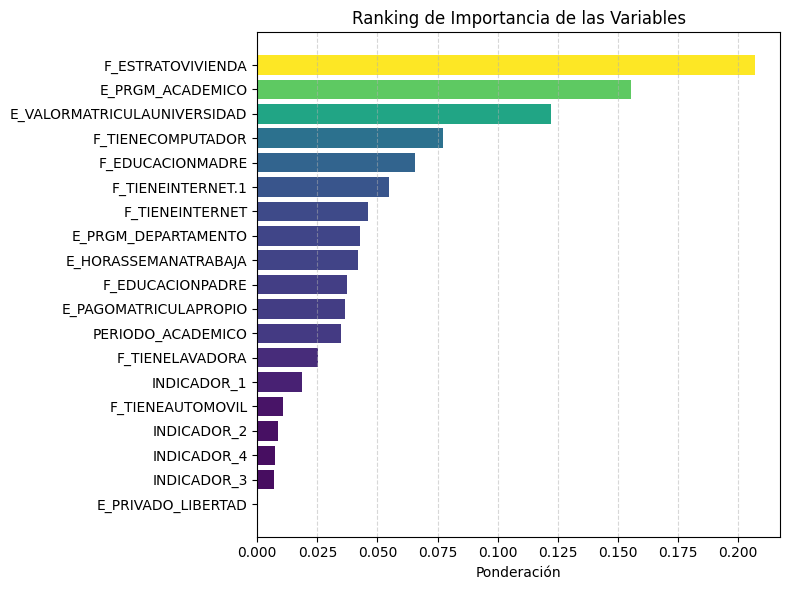

In [26]:
# Extraer la importancia de cada característica desde el modelo
feature_scores = xgb_classifier.feature_importances_

# Crear un DataFrame para organizar y visualizar las importancias
importance_df = (
    pd.DataFrame({'Variable': X.columns, 'Ponderación': feature_scores})
    .sort_values('Ponderación', ascending=True)  # ya ordenado para barh
    .reset_index(drop=True)
)

print("Importancia de las variables en el modelo:")
print(importance_df)

# Visualización de las importancias con estilo alternativo
plt.figure(figsize=(8, 6))
bars = plt.barh(
    importance_df['Variable'],
    importance_df['Ponderación'],
    color=plt.cm.viridis(importance_df['Ponderación'] / max(importance_df['Ponderación']))
)

plt.xlabel("Ponderación")
plt.title("Ranking de Importancia de las Variables")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# **Predicción Kaggle**

In [28]:
# Copia del test limpio
df_test = test_df2.copy()

# Guardar los IDs
ids = df_test["ID"].copy()

# Quitar columnas no necesarias
df_test.drop(columns=["ID", "Unnamed: 0"], axis=1, inplace=True, errors='ignore')

# Predecir con el modelo
predicciones = xgb_classifier.predict(df_test)

# Crear DataFrame de resultados
submission = pd.DataFrame({
    "ID": ids,
    "RENDIMIENTO_GLOBAL": predicciones
})

# Aplicar función para revertir los códigos, si existe
if 'rendimientoglobalreverse' in globals():
    submission = rendimientoglobalreverse(submission)

# Mostrar las primeras filas
print(submission.head())

# Guardar como CSV
submission.to_csv("submission.csv", index=False)
print("✅ Archivo submission.csv guardado correctamente.")

       ID RENDIMIENTO_GLOBAL
0  550236               bajo
1   98545         medio-alto
2  499179               alto
3  782980               bajo
4  785185               bajo
✅ Archivo submission.csv guardado correctamente.
